In [1]:
from PIL import Image
import torch
import depth_pro
import os
import numpy as np
# Lưu theo format depth-pro
import depth_pro.utils as utils

# **Depth Pro Demo**

In [39]:

# Hàm để lấy device GPU nếu có
def get_torch_device() -> torch.device:
    """Get the Torch device."""
    device = torch.device("cuda:0")
    if torch.cuda.is_available() == False:
        print("No GPU found, using CPU.")
        device = torch.device("cpu")
    elif torch.backends.mps.is_available():  # Cho MacOS với Apple Silicon
        device = torch.device("mps")
    return device

# Load model và preprocessing transform với GPU
device = get_torch_device()
model, transform = depth_pro.create_model_and_transforms(
    device=device,
    precision=torch.half  # Sử dụng half precision để tiết kiệm VRAM
)
model.eval()  # Chuyển model sang chế độ đánh giá
print("Model loaded successfully.")
print(f"Using device: {device}")


D:\Documents\UIT\Nam_3\ComputerVision\Depth-Pro\src\depth_pro\depth_pro.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(config.checkpoint_uri, 

Model loaded successfully.
Using device: cuda:0


In [45]:
img_dir = "./img/"
image_name = "image-3.png"
image_path = img_dir + image_name
# Load and preprocess an image.
image, _, f_px = depth_pro.load_rgb(image_path)
image = transform(image)

# Run inference.
prediction = model.infer(image, f_px=f_px)
depth = prediction["depth"]  # Depth in [m].
focallength_px = prediction["focallength_px"]  # Focal length in pixels.

In [46]:

output_path = "output/"
os.makedirs(output_path, exist_ok=True)

# Lưu depth map
depth_output = os.path.join(output_path, image_name + ".npy")
np.save(depth_output, depth.cpu().numpy())

# Lưu focal length
focal_output = os.path.join(output_path, image_name+ "_focal_length.txt")
with open(focal_output, "w") as f:
    f.write(f"{focallength_px}")

print(f"Results saved to {output_path}")

Results saved to output/


In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Đọc file
depth = np.load(depth_output)

# Xem thông tin cơ bản
print(f"Shape: {depth.shape}")
print(f"Data type: {depth.dtype}")
print(f"Min value: {depth.min()}")
print(f"Max value: {depth.max()}")
print(f"Mean value: {depth.mean()}")

Shape: (460, 818)
Data type: float32
Min value: 1.0585846900939941
Max value: 10000.0
Mean value: 3432.6005859375


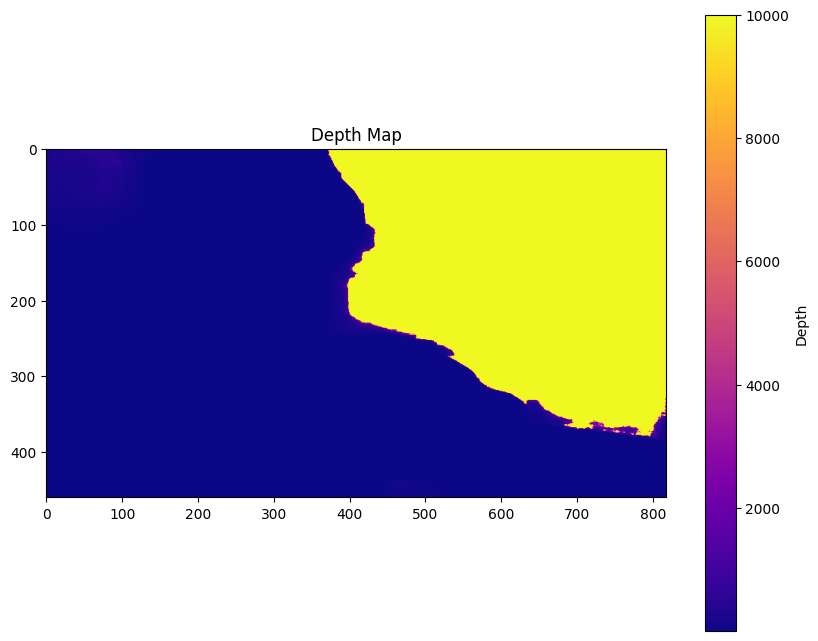

In [48]:
# Hiển thị và lưu depth map
plt.figure(figsize=(10, 8))
plt.imshow(depth, cmap='plasma')
plt.colorbar(label='Depth')
plt.title('Depth Map')

# Lưu hình trước khi hiển thị
plt.savefig(output_path + image_name + '_depth_map.png')

# Hiển thị sau khi đã lưu
plt.show()


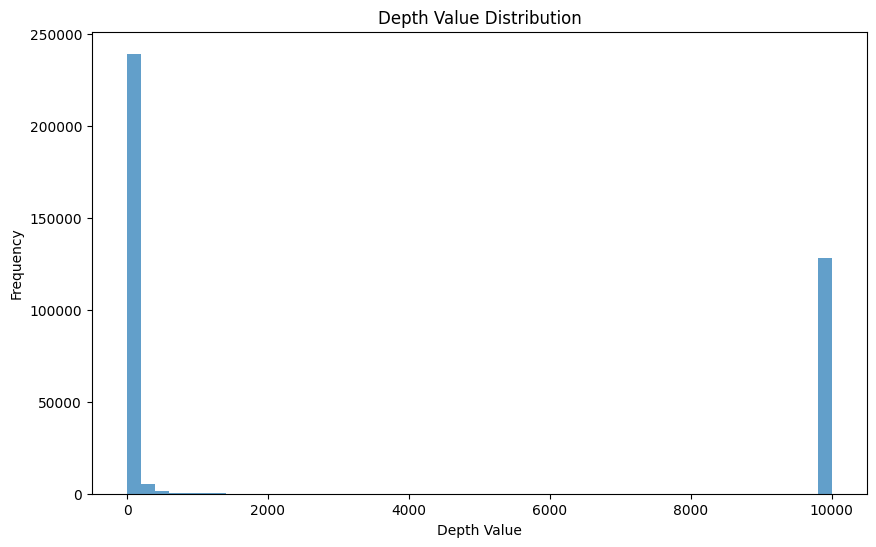

In [49]:
plt.figure(figsize=(10, 6))
plt.hist(depth.flatten(), bins=50, alpha=0.7)
plt.xlabel('Depth Value')
plt.ylabel('Frequency')
plt.title('Depth Value Distribution')
plt.show()